# Tutorial 1 - Getting started

In [1]:
import os
from IPython import display

In [3]:
import imagingplus as ip


imported imagingplus successfully
	version: 0.2-beta



This notebook demonstrates a basic workflow through `imaging+`. We will take raw input files and create a multi-level data object that can be used for calcium imaging data processing and analysis.

This tutorial is based off an existing 2photon imaging experiment that includes multiple trials of 2photon imaging experiments.

There are 3 minimum requirements for data inputs:
1) ImagingData: multipage tiff file of live imaging
2) TemporalData: temporal synchronization file of 1-d timeseries channels containing at minimum: imaging frame timing signals
3) MicroscopeMetadata: microscope metadata file containing at minimum: !!##

**The `imaging+` pipeline starts with creating an `Experiment` object. The `Experiment` object collects multiple experimental imaging trials from the same imaging field of view**

## Creating an experiment - UPDATED Jan 2024

The first step towards starting the analysis pipeline and creating the `Experiment` object is to create a dictionary (`ExperimentMetainfo`) to collect the metadata fields required for initializing `Experiment`. In `ExperimentMetainfo`, we provide initial information about the experiment.

Once created, the new `Experiment` gets saved to the disk using python's pickle protocol at the location specified in the `saveDir` field while creating the Experiment.

Note: UPDATE FIELDS IN THE `ExperimentMetainfo` DICTIONARY WITH YOUR OWN DATA PATHS AND EXPERIMENTAL INFORMATION.


In [ ]:
# !! UPDATE THESE FIELDS FOR YOUR OWN DATA PATHS AND EXPERIMENT DESCRIPTIONS !!
ExperimentMetainfo = {
    'dataPath': '/home/pshah/mnt/qnap/Data/2020-12-19',  #: main dir where the imaging data is contained
    'saveDir': '/mnt/qnap_share/Data/imagingplus-example/',  #: main dir where the experiment object and the trial objects will be saved to
    "expID": 'RL109',  #: given identification name for experiment
    'comment': 'date: 2020-12-19',  #: notes related to experiment
}

# create Experiment
expobj = ip.Experiment(**ExperimentMetainfo)


### Loading and Saving Experiment objects

We can read the `Experiment` that we just created and was saved to disk using the `import_obj()` function. Note that this function can be used to load any type of `imaging+` objects from disk.


We can also save `Experiment` at anytime to disk using `.save()`

In [13]:
# we can now load the new expobj from disk storage using pickle in ip.import_obj():
expobj = ip.import_obj('/mnt/qnap_share/Data/imagingplus-example/RL109_analysis.pkl')


|- Loaded imagingplus.Experiment object (expID: RL109)



In [14]:
# saving the Experiment object can be done anytime to disk from `expobj.save()`:
expobj.save()

# to save the Experiment with a custom path, provide a custom .pkl path and use the .save_pkl() method:
expobj.save_pkl(pkl_path='/mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl')


	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_analysis.pkl -- 

saving new pkl object at: /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl

	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl -- 


In [15]:
# Note that this updates the save path for this object:
print(expobj.pkl_path)

/mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl


## Adding trials to an experiment

After creating the initial `Experiment`, we move onto adding each individual imaging trial acquisition to this `expobj`.

We create each `ImagingTrial` session by creating a Metainfo dictionary that contains meta-information about each trial.

The `ImagingTrial` is the primary data container and the object that we will interact with most directly througout all steps of the package.




### Two-Photon Imaging Trial

There are two types of built-in `ImagingTrial` types: `TwoPhotonImaging` and `AllOpticalTrial`.

In this Tutorial, we will add 2x 2-photon imaging trials to our `Experiment`.

The 3 basic data requirements for any `ImagingTrial` are:
1) ImagingData - the calcium imaging data of the field of view
2) TemporalData - the temporal syncronization data which contains frame capture timing signals along with other channels to synchronize hardware within a given imaging experiment
3) MicroscopeMetadata - the microscope's imaging parameters (e.g. imaging frame rate, field of view size)

NOTE the specific data structure of the imaging data used below in this tutorial:
1) ImagingData --> .tiff file
2) TemporalData --> PaqData (reading from .paq files - PackIO used for temporal synchronization of 1-d timeseries channels)
2) MicroscopeMetadata --> PrairieViewMetadata (imaging system: PrairieView from Bruker 2pPlus)

TODO: create new cell here:

2023-12-08: [to assign] update Tutorial-1-Overview from PaqData --> TemporalData, and PrairieViewMetadata --> MicroscopeMetadata
    - or atleast just add example for user to input the necessary info manually, and then have another cell where it is automatically parsed for PaqData and PrairieViewMetadata (to show examples of built-ins)


In [ ]:
# we will utilize built-in data-form specific modules (PaqData and PrairieViewMetadata) to add TemporalData (.paq files) and MicroscopeMetadata (PrairieViewMetadata)
from imagingplus.main.subcore import TemporalData, MicroscopeMetadata
from imagingplus.processing.paq import PaqData
from imagingplus.processing.microscopes import PrairieViewMetadata

date = '2020-12-19'
prep = expobj.expID

# create trial obj for 2x trials:
trials_list_spont = ['t-005', 't-006']
for idx, trial in enumerate(trials_list_spont):

    # define paths to assign ImagingData from disc
    dataPath = f'/home/pshah/mnt/qnap/Data/2020-12-19/{date}_{trial}/{date}_{trial}_Cycle00001_Ch3.tif'
    
    # initialize MicroscopeMetadata for current imaging trial using built-in function for Bruker-PrairieView microscope data
    imparams = PrairieViewMetadata(pv_xml_dir=os.path.dirname(dataPath), microscope='Bruker 2pPlus')
    # NOTE: for microscopes without built-in support, please use the generic MicroscopeMetadata() class
    
    # create TemporalData by reading .paq file
    paqs_loc = f'/home/pshah/mnt/qnap/Data/2020-12-19/{date}_{prep}_{trial[-3:]}.paq'  # path to the .paq files for the selected trials
    paq_data, paq_rate, channels = PaqData.paq_read(file_path=paqs_loc, plot=False)

    tmdata = TemporalData(file_path=paqs_loc, sampling_rate=paq_rate, channels=channels, data=paq_data)

    # feed in information into `TwoPhotonImaging` to create a TwoPhotonImaging object
    trialobj = ip.TwoPhotonImaging(date=date, trialID= trial, expID= prep, imparams =  imparams, tmdata= tmdata,
                                saveDir=f'/mnt/qnap_share/Data/imagingplus-example/imagingplus-test-analysis/',
                                dataPath= dataPath, expGroup= "awake spont. 2p imaging + LFP")
    

    # add each Trial to the overall Experiment using the trialobj
    expobj.add_imaging_trial(trialID=trial, trialobj=trialobj)

In [18]:
# save the experiment object after adding new trials
expobj.save()
print(expobj) # look at information about our Experiment after adding the ImagingTrials


	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl -- 
imagingplus Experiment object (last saved: Sun Oct 23 12:59:35 2022), expID: RL109
file path: /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl

trials in Experiment object:
	t-005: awake spont. 2p imaging + LFP
	t-006: awake spont. 2p imaging + LFP



**We can see above now that our `Experiment` contains two newly added `TwoPhotonImagingTrial`.**

In [19]:
# we can access each trial's information from within the `expobj`
expobj.TrialsInformation

{'t-005': {'date': '2020-12-19',
  'trialID': 't-005',
  'expID': 'RL109',
  'expGroup': 'awake spont. 2p imaging + LFP',
  'comment': '',
  'paths': {'dataPath': '/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-005/2020-12-19_t-005_Cycle00001_Ch3.tif',
   'pkl_path': '/mnt/qnap_share/Data/imagingplus-example/imagingplus-test-analysis/2020-12-19_t-005.pkl',
   'data_path': '/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-005/2020-12-19_t-005_Cycle00001_Ch3.tif',
   'data_path_dir': '/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-005'}},
 't-006': {'date': '2020-12-19',
  'trialID': 't-006',
  'expID': 'RL109',
  'expGroup': 'awake spont. 2p imaging + LFP',
  'comment': '',
  'paths': {'dataPath': '/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-006/2020-12-19_t-006_Cycle00001_Ch3.tif',
   'pkl_path': '/mnt/qnap_share/Data/imagingplus-example/imagingplus-test-analysis/2020-12-19_t-006.pkl',
   'data_path': '/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-006/2020-12-19_t-006_

In [20]:
# we can also load each trial directly from the experiment:
trialobj = expobj.load_trial(trialID = 't-005')


|- Loaded 'RL109 t-005 (TwoPhotonImagingTrial experimental object)'t-analysis/2020-12-19_t-005.pkl ... 



### AllOptical Trial - TODO replace into its own tutorial

Next, we will add an `AllOpticalTrial` to our `Experiment`.


\- Adding Imaging Acquisition Metadata from Bruker 2pPlus ...

	\- Parsing PV Metadata for Bruker microscope...
	 searching for xml path in tiff path directory at: /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013 ... 
	n planes: 1 
	n frames: 16368 
	fps: 29.75972061098135 
	frame size (px): 512 y 512 
	zoom: 1.0 
	pixel size (um): 2.18458479264539 2.18458479264539 
	scan centre (V): 0.0 0.0
	loading Paq cellsdata from: /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_RL109_013.paq
	 - loaded 8 channels from .Paq file: ['frame_clock', 'x_galvo_uncaging', 'slm2packio', 'markpoints2packio', 'packio2slm', 'packio2markpoints', 'pycontrol_rsync', 'voltage']

\- ADDING PAQ DATA from /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_RL109_013.paq... 
	loading Paq cellsdata from: /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_RL109_013.paq


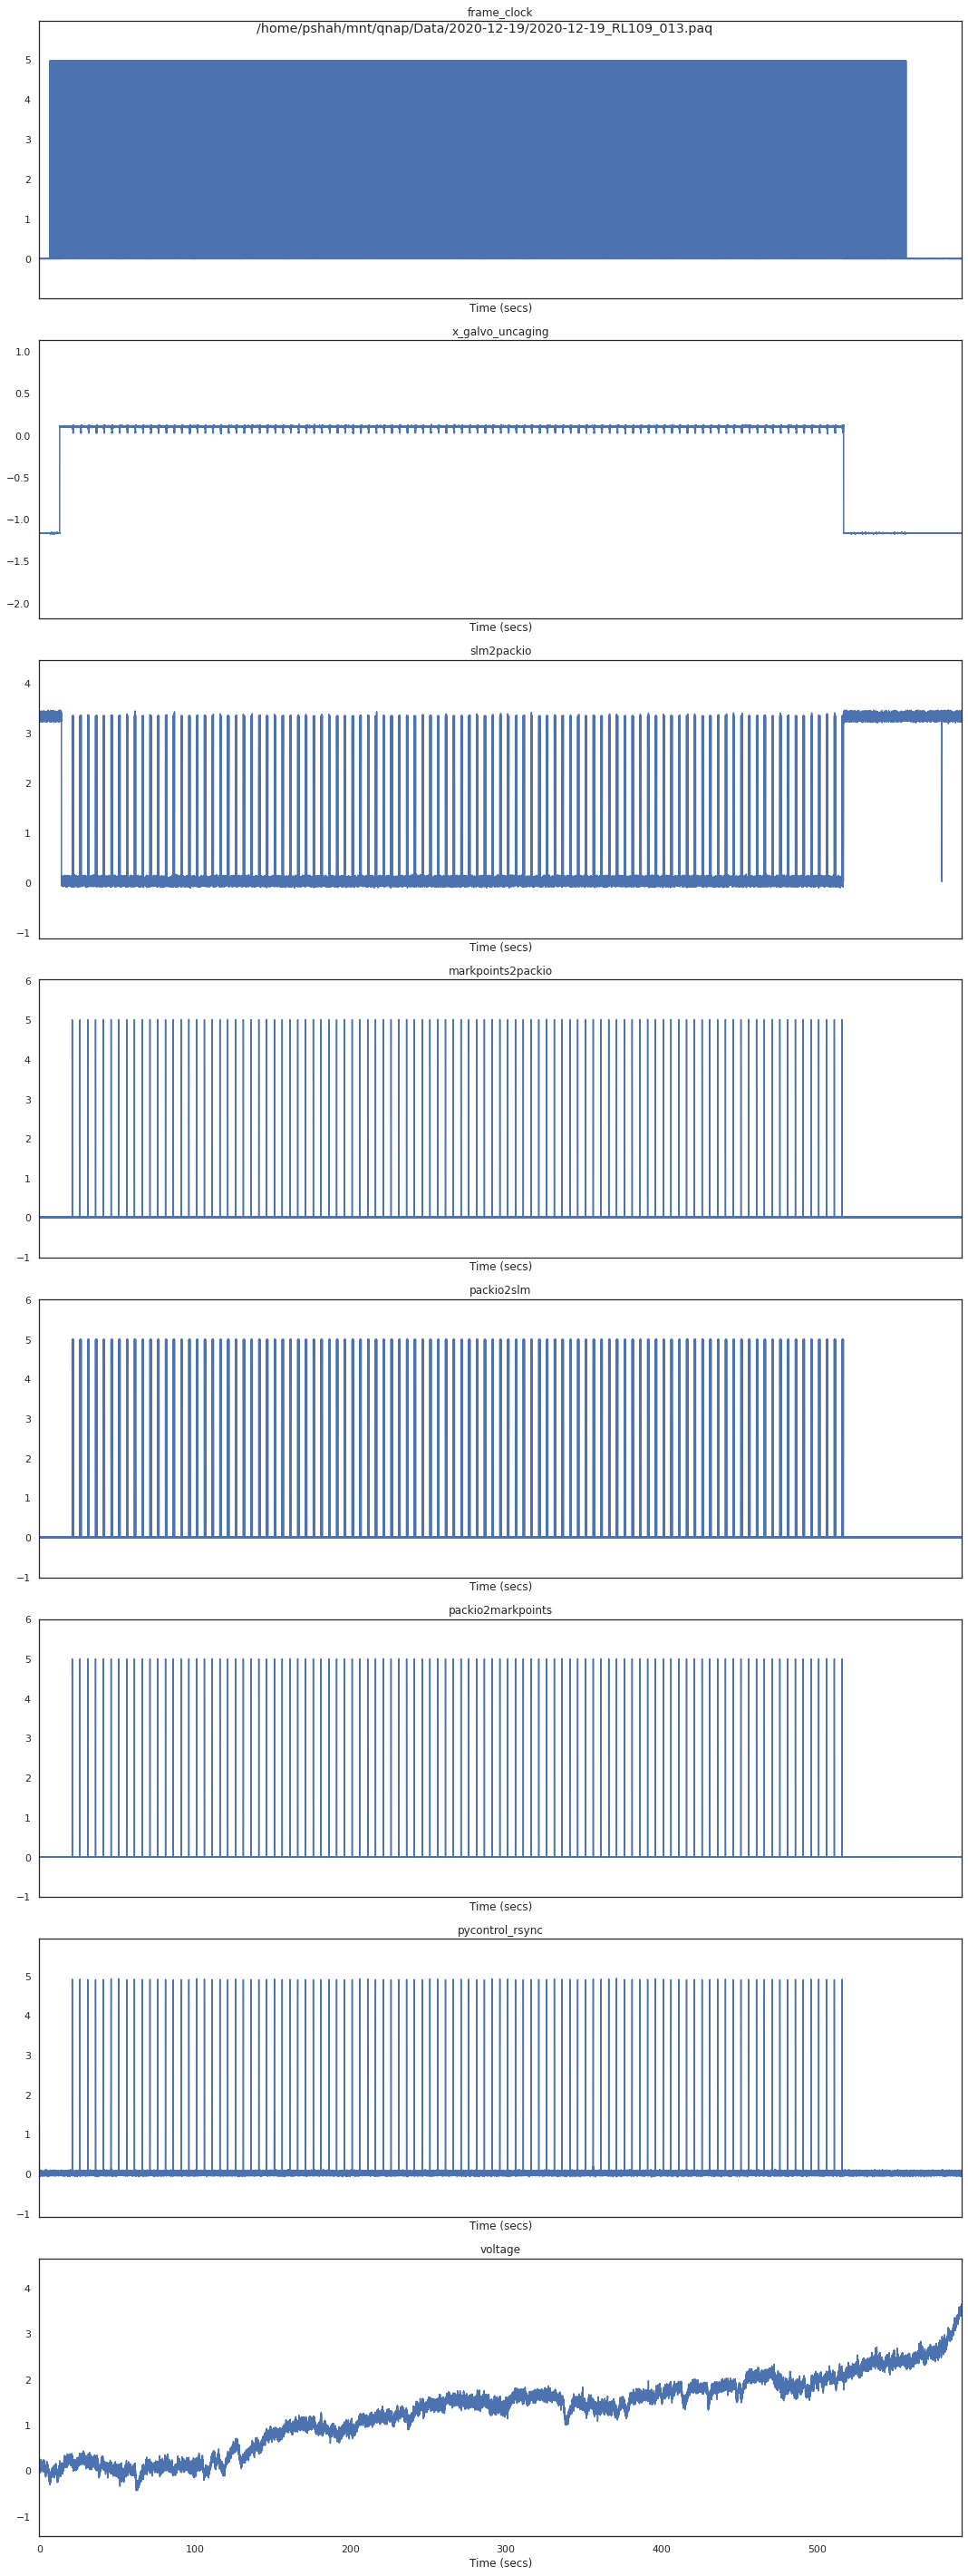

	 - loaded 8 channels from .Paq file: ['frame_clock', 'x_galvo_uncaging', 'slm2packio', 'markpoints2packio', 'packio2slm', 'packio2markpoints', 'pycontrol_rsync', 'voltage']
Created new TemporalData of 8 x 11864768 (sampled at 20000

	\- Retrieving two-photon imaging frame times from .paq channel: frame_clock ... 

	\- Getting imaging key frames timed cellsdata from 16376 frames ... 
		\- Adding sparse tmdata for channel: frame_clock 
		\- Adding sparse tmdata for channel: x_galvo_uncaging 
		\- Adding sparse tmdata for channel: slm2packio 
		\- Adding sparse tmdata for channel: markpoints2packio 
		\- Adding sparse tmdata for channel: packio2slm 
		\- Adding sparse tmdata for channel: packio2markpoints 
		\- Adding sparse tmdata for channel: pycontrol_rsync 
		\- Adding sparse tmdata for channel: voltage 
	|- Collected sparse data:  (16376, 8) ... 
# of stims found on markpoints2packio: 100


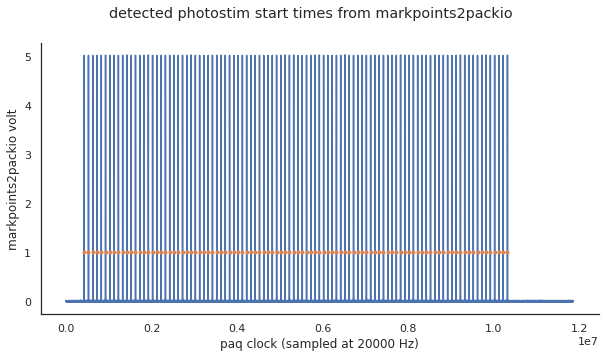

In [21]:
from imagingplus.processing.paq import PaqData
from imagingplus.processing.microscopes import PrairieViewMetadata


date = '2020-12-19'
prep = expobj.expID

# define paths to retrieve data from disc
paqs_loc = f'/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_RL109_013.paq'  # path to the .paq files for the selected trials
dataPath = f'/home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013/2020-12-19_t-013_Cycle00001_Ch3.tif'


initialization_dict = {'naparm_path': f'/home/pshah/mnt/qnap/Data/2020-12-19/photostim/2020-12-19_RL109_ps_014/',
                       'dataPath': dataPath,
                       'saveDir': f'/home/pshah/mnt/qnap/Data/2020-12-19/',
                       'date': '2020-12-19',
                       'trialID': 't-013',
                       'expID': 'RL109',
                       'expGroup': 'all optical trial with LFP',
                       'comment': 'n/a'}

# parses imaging system cellsdata
imparams = PrairieViewMetadata(pv_xml_dir=os.path.dirname(dataPath), microscope='Bruker 2pPlus')

# sets the stim start frames
tmdata = PaqData.paqProcessingAllOptical(paq_path=paqs_loc, frame_channel='frame_clock',
                                         stim_channel='markpoints2packio', plot=False)
    

In [22]:
# create a sparse version of all temporal data series timealigned to frame times
tmdata.sparse_data = tmdata.get_sparse_data()


	\- Getting imaging key frames timed cellsdata from 16376 frames ... 
		\- Adding sparse tmdata for channel: frame_clock 
		\- Adding sparse tmdata for channel: x_galvo_uncaging 
		\- Adding sparse tmdata for channel: slm2packio 
		\- Adding sparse tmdata for channel: markpoints2packio 
		\- Adding sparse tmdata for channel: packio2slm 
		\- Adding sparse tmdata for channel: packio2markpoints 
		\- Adding sparse tmdata for channel: pycontrol_rsync 
		\- Adding sparse tmdata for channel: voltage 
	|- Collected sparse data:  (16376, 8) ... 


In [23]:
# create the trial
aotrial = ip.AllOpticalTrial(imparams=imparams, tmdata=tmdata, **initialization_dict)

\----- CREATING TwoPhotonImagingTrial for trial: t-013

-----collecting mean raw flu trace from tiff file...
saving new trial object to: /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013.pkl

	 -- data object saved to /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013.pkl -- 

	 -- data object saved to /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013.pkl -- 

\----- parsing Naparm xml file...
loading NAPARM_xml_path:
['/home/pshah/mnt/qnap/Data/2020-12-19/photostim/2020-12-19_RL109_ps_014/2020-12-19_RL109_ps_014.xml']
	Numbers of trials: 100 
	Number of groups: 4 
	Number of shots: 10 
	Number of sequence reps: 1 
	Inter-point delay: 5 
	Spiral Duration (ms): 20

\----- parsing Naparm gpl file...
['/home/pshah/mnt/qnap/Data/2020-12-19/photostim/2020-12-19_RL109_ps_014/2020-12-19_RL109_ps_014.gpl']
loading NAPARM_gpl_path:  /home/pshah/mnt/qnap/Data/2020-12-19/photostim/2020-12-19_RL109_ps_014/2020-12-19_RL109_ps_014.gpl
Single stim dur (ms): 10
Spiral size .gpl file: 0.0475

In [24]:
expobj.add_imaging_trial(trialobj=aotrial)




\- ADDING trial: t-013 to RL109 experiment
	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl -- 
|- ADDED trial: t-013 to RL109 experiment


In [25]:
print(expobj)

imagingplus Experiment object (last saved: Sun Oct 23 13:02:29 2022), expID: RL109
file path: /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl

trials in Experiment object:
	t-005: awake spont. 2p imaging + LFP
	t-006: awake spont. 2p imaging + LFP
	t-013: all optical trial with LFP



In [26]:
# save the experiment object after adding new trials
expobj.save()



	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl -- 


## Adding calcium imaging processing to Experiment

After creating the Experiment and loading each Trial, we can move on to data analysis. 

We start with adding `Suite2p` functionality to our Experiment. 

We provide helpful wrapper functions that allow quick access `Suite2p` functionality directly from the `Experiment` or the `ImagingTrial`.

`Suite2p` results provides both `CellAnnotations` and `ImagingData` to each `ImagingTrial`

In [27]:
# we plan to use all trials from the experiment for Suite2p
expobj.add_suite2p(s2p_trials=['t-005', 't-006', 't-013'],
                  s2pResultsPath="/home/pshah/mnt/qnap/Analysis/2020-12-19/suite2p/alloptical-2p-1x-alltrials/plane0/")


\- Adding suite2p module to experiment. Located under .Suite2p
\----- Adding Suite2p results to .Suite2p module ...
Loading 640 traces labelled as cells
|- Loaded [1] suite2p classified cells from plane 0, recorded for 8533.93 secs total, 256018 frames total
|- ADDED .Suite2p module to Experiment object. 

|- Loaded 'RL109 t-005 (TwoPhotonImagingTrial experimental object)'t-analysis/2020-12-19_t-005.pkl ... 


	|- current trial key_frames: (0, 14880) out of 256018 total key_frames processed through suite2p
\- added CellAnnotations module. consisting of 15 annotations x 640 cells.
\- added ImagingData module. consisting of (640, 14880) ROIs x Frames.

\----- ADDED .Suite2p module to trial. 
	 -- data object saved to /mnt/qnap_share/Data/imagingplus-example/imagingplus-test-analysis/2020-12-19_t-005.pkl -- 

|- Loaded 'RL109 t-006 (TwoPhotonImagingTrial experimental object)'t-analysis/2020-12-19_t-006.pkl ... 


	|- current trial key_frames: (14880, 38053) out of 256018 total key_frames 

In [28]:
# save the experiment object after adding new trials
expobj.save()

expobj.save_pkl('/mnt/qnap_share/Data/imagingplus-example/RL109_analysis.pkl')


	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_duplicate_analysis.pkl -- 

saving new pkl object at: /mnt/qnap_share/Data/imagingplus-example/RL109_analysis.pkl

	|- Experiment analysis object saved to /mnt/qnap_share/Data/imagingplus-example/RL109_analysis.pkl -- 


In [29]:
# direct access to important Suite2p outputs from ImagingTrial and the Experiment instances
print(expobj.Suite2p)

Suite2p Results (Experiment level) Object, containing trials: 
	['t-005', 't-006', 't-013']


In [30]:
aotrial.Suite2p

### Load all-optical trial

In [31]:
aotrial = expobj.load_trial(trialID = 't-013')


|- Loaded TwoPhotonImagingTrial.alloptical experimental trial object ... 



## Storing Suite2p processed data as an anndata structure

In [35]:
# create annotated data object 

# anndata storage submodule
aotrial.data = aotrial.create_anndata(imdata=aotrial.Suite2p,
                                     cells=aotrial.Suite2p,
                                     tmdata=aotrial.tmdata.sparse_data,
                                     imdata_type='suite2p raw - neuropil corrected')

aotrial.save()


\----- CREATING annotated cellsdata object using AnnData:
Created AnnData object: 
	Annotated Data of n_obs (# ROIs) × n_vars (# Frames) = 640 × 16368

Annotated Data of n_obs × n_vars = 640 × 16368 
available attributes: 
	.X (primary datamatrix) of .data_label: 
		|- suite2p raw - neuropil corrected
	.obs (obs metadata): 
		|- 'ypix', 'xpix', 'lam', 'footprint', 'mrs', 'mrs0', 'compact', 'med', 'npix', 'overlap', 'radius', 'aspect_ratio', 'npix_norm', 'skew', 'std'
	.var (vars metadata): 
		|- 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'markpoints2packio', 'packio2slm', 'packio2markpoints', 'pycontrol_rsync', 'voltage'
	.obsm: 
		|- 'ypix', 'xpix'

	 -- data object saved to /home/pshah/mnt/qnap/Data/2020-12-19/2020-12-19_t-013.pkl -- 


In [36]:
# all data streams can be accessed directly out of one variable (yes, one variable!!)
print(aotrial.data)

Annotated Data of n_obs × n_vars = 640 × 16368 
available attributes: 
	.X (primary datamatrix) of .data_label: 
		|- suite2p raw - neuropil corrected
	.obs (obs metadata): 
		|- 'ypix', 'xpix', 'lam', 'footprint', 'mrs', 'mrs0', 'compact', 'med', 'npix', 'overlap', 'radius', 'aspect_ratio', 'npix_norm', 'skew', 'std'
	.var (vars metadata): 
		|- 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'markpoints2packio', 'packio2slm', 'packio2markpoints', 'pycontrol_rsync', 'voltage'
	.obsm: 
		|- 'ypix', 'xpix'


In [34]:
aotrial.tmdata.data

,frame_clock,x_galvo_uncaging,slm2packio,markpoints2packio,packio2slm,packio2markpoints,pycontrol_rsync,voltage,stim_start_times
0,0.005525,-1.167153,3.338084,0.005854,-0.001710,0.000264,1.320265,0.055181,False
1,0.005854,-1.166824,3.339728,0.007827,0.000264,-0.000065,1.237395,0.053866,False
2,0.005854,-1.165509,3.336768,0.007169,-0.000394,0.000592,1.158142,0.056168,False
3,0.005525,-1.166495,3.334138,0.006183,-0.000065,0.000264,1.084809,0.054524,False
4,0.005854,-1.166824,3.331178,0.007169,0.002565,0.000592,1.018710,0.055510,False
...,...,...,...,...,...,...,...,...,...
11864763,0.006512,-1.165837,3.331836,0.008156,0.001579,0.000921,0.022296,3.461073,False
11864764,0.007498,-1.165180,3.333151,0.006512,0.000592,0.000592,0.018679,3.461402,False
11864765,0.006512,-1.164851,3.335782,0.007827,-0.001052,0.000264,0.018350,3.461731,False
11864766,0.008485,-1.164851,3.341701,0.008156,-0.000065,0.000592,0.020323,3.461073,False
